In [503]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as mplt

from pathlib import Path

pd.set_option('display.max_rows', None)

We set some parameters to be used accross all notebook analysis.

In [504]:
SOURCE_LANGUAGES = ["en", "ru", "zh"]
FINETUNE_SIZES   = [6000000, 19000000, 60000000, 189000000, 600000000, 6000000000]

## Preparing the Data

In [505]:
raw_data = pd.read_csv("../results/experiments.csv")
raw_data.head()

,Unnamed: 0,loss,step,url,bucket,filename,initialization,target,model_size,data_size
0,0,2.543823,120,models/finetune/scratch_fi_small_6M/,lang_agnostic,scratch_fi_small_6M,scratch,fi,small,6M
1,1,0.893227,22890,models/finetune/en_fi_small_6B/,lang_agnostic,en_fi_small_6B,en,fi,small,6B
2,2,0.721926,12595,models/finetune/en_ru_small_60M/,lang_agnostic,en_ru_small_60M,en,ru,small,60M
3,3,0.705878,21750,models/finetune/en_ar_small_600M/,lang_agnostic,en_ar_small_600M,en,ar,small,600M
4,4,1.079616,11741,models/finetune/en_es_small_19M/,lang_agnostic,en_es_small_19M,en,es,small,19M


All size names are in the format `{number}{multiplier indicator}`. So, to be able to sort by those sizes, we convert them to their bytes.

In [506]:
MULTIPLIERS = {
    "M": 1000000,
    "B": 1000000000,
}

def convert_size_to_number(number_repr):
    suffix = number_repr[-1]
    multiplier = MULTIPLIERS[suffix]
    number_part = number_repr[:-1]
    
    return int(number_part) * multiplier


convert_size_to_number("65M")

65000000

We add some additional columns to help in the experiment analysis. Among them we have:

- *size*: a numeric representation of the data size
- *cross_lingual*: indicates whether or not the experiment uses a different language in initialization (from target)
- *perplexity*: we calculate the perplexitr from loss

In [507]:
raw_data["size"] = raw_data["data_size"].apply(convert_size_to_number)
raw_data["cross_lingual"] = raw_data["initialization"] != raw_data["target"]
raw_data["perplexity"] = np.exp(raw_data["loss"])

raw_data.head()

,Unnamed: 0,loss,step,url,bucket,filename,initialization,target,model_size,data_size,size,cross_lingual,perplexity
0,0,2.543823,120,models/finetune/scratch_fi_small_6M/,lang_agnostic,scratch_fi_small_6M,scratch,fi,small,6M,6000000,True,12.728236
1,1,0.893227,22890,models/finetune/en_fi_small_6B/,lang_agnostic,en_fi_small_6B,en,fi,small,6B,6000000000,True,2.442999
2,2,0.721926,12595,models/finetune/en_ru_small_60M/,lang_agnostic,en_ru_small_60M,en,ru,small,60M,60000000,True,2.058394
3,3,0.705878,21750,models/finetune/en_ar_small_600M/,lang_agnostic,en_ar_small_600M,en,ar,small,600M,600000000,True,2.025625
4,4,1.079616,11741,models/finetune/en_es_small_19M/,lang_agnostic,en_es_small_19M,en,es,small,19M,19000000,True,2.943550


In [508]:
cross_lingual_data = raw_data[raw_data.cross_lingual == True]

target_v_initialization = pd.pivot_table(cross_lingual_data, index=["target", "size"], columns="initialization", values="perplexity")
target_v_initialization[["scratch", "en", "ru", "zh"]]

initialization       scratch        en        ru        zh
target size                                               
ar     0           11.099188  4.471012  7.586950  4.539179
       6000000      6.443963  2.818745  2.830716  2.880094
       19000000     5.398603  2.573541  2.614603  2.678952
       60000000     3.111124  2.382326  2.438054  2.461752
       189000000    2.384848  2.169670  2.172620  2.208565
       600000000    2.105888  2.025625  2.031723  2.059278
       6000000000   1.929630  2.141356  1.930613  2.082330
de     0           24.134190  4.557543  5.585567  6.370033
       6000000     14.815842  3.666850  3.984010  4.264022
       19000000    10.295130  3.440617  3.626220  3.887831
       60000000     3.921004  3.107374  3.284250  3.342238
       189000000    3.206312  2.889578  2.970552  3.032195
       600000000    2.791715  2.680328  2.706459  2.747532
       6000000000   2.549487  2.654847       NaN  2.707397
en     6000000     16.275217       NaN  3.662180  3.885537
       60000000     3.917610       NaN  3.226690       NaN
       600000000    2.849276       NaN  2.776846       NaN
       6000000000   2.815416       NaN       NaN       NaN
es     6000000     12.539025  3.163111  3.474664  3.752540
       19000000     9.372363  2.943550  3.133820  3.519423
       60000000     3.570520  2.741453  2.855067  2.987010
       189000000    2.850784  2.581411  2.634654  2.692495
       600000000    2.546002  2.408924  2.419389  2.455862
       6000000000   2.668534  2.390901       NaN  2.445876
fi     0           18.774242  5.724296  6.590427  6.933383
       6000000     12.714645  3.568337  3.800116  3.979684
       19000000     9.099923  3.237693  3.379644  3.556140
       60000000     3.725819  2.901409  3.006726  3.128807
       189000000    2.953213  2.662845  2.714177  2.795455
       600000000    2.592097  2.488557  2.489909  2.525235
       6000000000   2.413621  2.442999       NaN  2.407570
id     0           22.865840  3.602278  4.706409  5.398109
       6000000     11.997169  2.609680  2.836732  2.977077
       19000000     7.772401  2.431387  2.579274  2.650573
       60000000     2.813704  2.276483  2.360225  2.410284
       189000000    2.322753  2.135157  2.188389  2.207095
       600000000    2.104967  2.025921  2.027535  2.050211
       6000000000   1.942082  2.001282       NaN  2.027612
ja     0           26.231975  6.079399  8.243286  4.716311
       6000000     12.468638  3.919586  3.891109  3.456637
       19000000     7.148220  3.322470  3.382605  3.155288
       60000000     3.551774  2.993006  3.023181  2.888835
       189000000    2.900728  2.706201  2.719937  2.649093
       600000000    2.540472  2.465089  2.454615  2.427642
       6000000000   2.277216  2.544193       NaN       NaN
ko     0           23.584094  6.394658  8.498488  5.190967
       6000000     11.686792  3.579865  3.584079  3.477913
       19000000     6.809712  3.112811  3.140066  3.124191
       60000000     3.334459  2.785987  2.822445  2.813633
       189000000    2.684107  2.526482  2.537097  2.543149
       600000000    2.386445  2.343350  2.336919  2.418162
       6000000000   2.220560  2.324495       NaN       NaN
ru     0            9.733962  3.579393       NaN       NaN
       6000000      6.269366  2.443826       NaN  2.721920
       19000000     4.886091  2.211513       NaN  2.287652
       60000000     2.540096  2.058394       NaN  2.086784
       189000000    2.049535  1.914023       NaN  2.016428
       600000000    1.866623  1.805038       NaN  1.828458
       6000000000   1.734547  1.801898       NaN       NaN
zh     0           29.921034  7.180575       NaN       NaN
       6000000     15.340176  4.425953  4.520740       NaN
       19000000     8.133923  3.793673  3.861322       NaN
       60000000     3.728360  3.059484  3.054910       NaN
       189000000    2.774915  2.620343  2.901177       NaN
       600000000    2.277762  2.375330       NaN       NaN
       6000000000   1.871711  1.963456       Na

## Calculating the Data Transfer in bytes

First, we group the results by Source Language (the language used to pretrain the model). For every source language, we keep a Data Table which contains the scratch results alongside with results for that language. 

In [509]:
by_lang = {lang: target_v_initialization[["scratch", lang]] for lang in ["en", "zh", "ru"]}
by_lang["zh"]

initialization       scratch        zh
target size                           
ar     0           11.099188  4.539179
       6000000      6.443963  2.880094
       19000000     5.398603  2.678952
       60000000     3.111124  2.461752
       189000000    2.384848  2.208565
       600000000    2.105888  2.059278
       6000000000   1.929630  2.082330
de     0           24.134190  6.370033
       6000000     14.815842  4.264022
       19000000    10.295130  3.887831
       60000000     3.921004  3.342238
       189000000    3.206312  3.032195
       600000000    2.791715  2.747532
       6000000000   2.549487  2.707397
en     6000000     16.275217  3.885537
       60000000     3.917610       NaN
       600000000    2.849276       NaN
       6000000000   2.815416       NaN
es     6000000     12.539025  3.752540
       19000000     9.372363  3.519423
       60000000     3.570520  2.987010
       189000000    2.850784  2.692495
       600000000    2.546002  2.455862
       6000000000   2.668534  2.445876
fi     0           18.774242  6.933383
       6000000     12.714645  3.979684
       19000000     9.099923  3.556140
       60000000     3.725819  3.128807
       189000000    2.953213  2.795455
       600000000    2.592097  2.525235
       6000000000   2.413621  2.407570
id     0           22.865840  5.398109
       6000000     11.997169  2.977077
       19000000     7.772401  2.650573
       60000000     2.813704  2.410284
       189000000    2.322753  2.207095
       600000000    2.104967  2.050211
       6000000000   1.942082  2.027612
ja     0           26.231975  4.716311
       6000000     12.468638  3.456637
       19000000     7.148220  3.155288
       60000000     3.551774  2.888835
       189000000    2.900728  2.649093
       600000000    2.540472  2.427642
       6000000000   2.277216       NaN
ko     0           23.584094  5.190967
       6000000     11.686792  3.477913
       19000000     6.809712  3.124191
       60000000     3.334459  2.813633
       189000000    2.684107  2.543149
       600000000    2.386445  2.418162
       6000000000   2.220560       NaN
ru     0            9.733962       NaN
       6000000      6.269366  2.721920
       19000000     4.886091  2.287652
       60000000     2.540096  2.086784
       189000000    2.049535  2.016428
       600000000    1.866623  1.828458
       6000000000   1.734547       NaN
zh     0           29.921034       NaN
       6000000     15.340176       NaN
       19000000     8.133923       NaN
       60000000     3.728360       NaN
       189000000    2.774915       NaN
       600000000    2.277762       NaN
       6000000000   1.871711       NaN

Then, we estimate:

- D<sub>E</sub>: which is the Data effective amout, or the amout of finetune tokens that should be given to a model initialized from scratch so it can reach the same perplexity as the model which was pretrained and finetuned with a specific size.
- D<sub>T</sub>: which is the Data Transfer amount, or the D<sub>E</sub> subtract from the finetune dataset size. This indicator accounts for the estimated number of tokens (or data size) that a pretrained model is leveraging from its pretraining routine.
- D<sub>F</sub>: which is the size of the finetune dataset.


For estimating D<sub>E</sub>, we use linear interpolation from the set of data points that holds the performance of a model finetuned from scratch.

In [510]:
estimations = {"source": [], "target": [], "size": [], "perplexity": [], "scratch_perplexity": [], "dt": [], "de": [], "df": []}

for lang, lang_data in by_lang.items():
    languages = by_lang[lang].index.get_level_values(0).unique().to_list()
    languages.remove(lang)  # removing itself, since we are interested in cross lingual experiments

    for target in languages:
        target_data = lang_data.loc[target]
        target_data = target_data[target_data.index.isin(FINETUNE_SIZES)] # We do not consider, at first, zero-shot experiments

        x_values = target_data.index.to_numpy()

        y_values = target_data["scratch"].to_numpy()
        y_values_dotted = target_data[lang].to_numpy()

        estimated_de = np.interp(x=y_values_dotted, xp=y_values, fp=x_values, period=10)
        estimated_dt = estimated_de - x_values

        estimations["source"].extend([lang] * len(x_values))
        estimations["target"].extend([target] * len(x_values))
        estimations["size"].extend(x_values)
        estimations["perplexity"].extend(y_values_dotted)
        estimations["scratch_perplexity"].extend(y_values)
        estimations["de"].extend(estimated_de)
        estimations["df"].extend(x_values)
        estimations["dt"].extend(estimated_dt)


estimated_dt_table = pd.DataFrame.from_dict(estimations)
estimated_dt_table.head()

,source,target,size,perplexity,scratch_perplexity,dt,de,df
0,en,ar,6000000,2.818745,6.443963,1.059319e+08,1.119319e+08,6000000
1,en,ar,19000000,2.573541,5.398603,1.364847e+08,1.554847e+08,19000000
2,en,ar,60000000,2.382326,3.111124,1.327154e+08,1.927154e+08,60000000
3,en,ar,189000000,2.169670,2.384848,3.170269e+08,5.060269e+08,189000000
4,en,ar,600000000,2.025625,2.105888,2.459007e+09,3.059007e+09,600000000


In [511]:
estimated_dt_table[(estimated_dt_table.source == "zh") & (estimated_dt_table.target == "en")]

,source,target,size,perplexity,scratch_perplexity,dt,de,df
66,zh,en,6000000,3.885537,16.275217,7.021128e+07,7.621128e+07,6000000
67,zh,en,60000000,NaN,3.917610,NaN,NaN,60000000
68,zh,en,600000000,NaN,2.849276,NaN,NaN,600000000
69,zh,en,6000000000,NaN,2.815416,NaN,NaN,6000000000


Also, we calculate the fraction of D<sub>T</sub> by D<sub>E</sub>, which tells us how much of the performance of the model is estimated to be related to pretraining and not finetuning only:

In [512]:
estimated_dt_table["fraction_of_effective_dt"] = np.maximum(estimated_dt_table["dt"] / estimated_dt_table["de"], 0)
estimated_dt_table.head(5)

,source,target,size,perplexity,scratch_perplexity,dt,de,df,fraction_of_effective_dt
0,en,ar,6000000,2.818745,6.443963,1.059319e+08,1.119319e+08,6000000,0.946396
1,en,ar,19000000,2.573541,5.398603,1.364847e+08,1.554847e+08,19000000,0.877801
2,en,ar,60000000,2.382326,3.111124,1.327154e+08,1.927154e+08,60000000,0.688660
3,en,ar,189000000,2.169670,2.384848,3.170269e+08,5.060269e+08,189000000,0.626502
4,en,ar,600000000,2.025625,2.105888,2.459007e+09,3.059007e+09,600000000,0.803858


Finally, we add some formatted versions for the indicator columns, so it is easier to read:

In [513]:
def format_in_mega(v):
    return '{:,.2f} MB'.format(v / 1024 / 1024)


estimated_dt_table["dt_formatted"] = estimated_dt_table["dt"].map(format_in_mega)
estimated_dt_table["df_formatted"] = estimated_dt_table["df"].map(format_in_mega)
estimated_dt_table["de_formatted"] = estimated_dt_table["de"].map(format_in_mega)

estimated_dt_table.head(10)

,source,target,size,perplexity,scratch_perplexity,dt,de,df,fraction_of_effective_dt,dt_formatted,df_formatted,de_formatted
0,en,ar,6000000,2.818745,6.443963,1.059319e+08,1.119319e+08,6000000,0.946396,101.02 MB,5.72 MB,106.75 MB
1,en,ar,19000000,2.573541,5.398603,1.364847e+08,1.554847e+08,19000000,0.877801,130.16 MB,18.12 MB,148.28 MB
2,en,ar,60000000,2.382326,3.111124,1.327154e+08,1.927154e+08,60000000,0.688660,126.57 MB,57.22 MB,183.79 MB
3,en,ar,189000000,2.169670,2.384848,3.170269e+08,5.060269e+08,189000000,0.626502,302.34 MB,180.24 MB,482.58 MB
4,en,ar,600000000,2.025625,2.105888,2.459007e+09,3.059007e+09,600000000,0.803858,"2,345.09 MB",572.20 MB,"2,917.30 MB"
5,en,ar,6000000000,2.141356,1.929630,-5.452257e+09,5.477426e+08,6000000000,0.000000,"-5,199.68 MB","5,722.05 MB",522.37 MB
6,en,de,6000000,3.666850,14.815842,9.987413e+07,1.058741e+08,6000000,0.943329,95.25 MB,5.72 MB,100.97 MB
7,en,de,19000000,3.440617,10.295130,1.277086e+08,1.467086e+08,19000000,0.870492,121.79 MB,18.12 MB,139.91 MB
8,en,de,60000000,3.107374,3.921004,2.270794e+08,2.870794e+08,60000000,0.790999,216.56 MB,57.22 MB,273.78 MB
9,en,de,189000000,2.889578,3.206312,3.139865e+08,5.029865e+08,189000000,0.624244,299.44 MB,180.24 MB,479.69 MB


## Utility Chart Functions

For helping with the visualization of the results, we create some helper functions for ploting charts.

In [514]:
def plot_by(data_table: pd.DataFrame,
            by: str,
            x: str,
            y: str,
            logx: bool = True,
            logy: bool = False,
            x_label: str = "Finetune dataset size",
            y_label: str="Dt",
            type: str = "-s",
            ymin_max = None
):
    """
    Plots, in the same chart, the values of (`x`, `y`) data points.
    Each unique value of `by` is plotted as a different series in the chart.
    """
    fig, ax = mplt.subplots(figsize=(10,4))

    mplt.xlabel(x_label)
    mplt.ylabel(y_label)

    grouped = data_table.groupby(by)

    for group_name, indexes in grouped.groups.items():
        subset = data_table.iloc[indexes]

        y_values = np.log(subset[y]) if logy else subset[y]
        x_values = np.log(subset[x]) if logx else subset[x]

        mplt.plot(x_values, y_values, type, label=group_name)

    if ymin_max:
        ax.set_ylim(*ymin_max)

    mplt.legend()

In [515]:
def plot_chart_for_dt(target_language_data,
                      source_language,
                      target_language,
                      dt_table = None):
    """
    Plot a chart with both Perplexity curves: for a model trained from scratch and pretrained in `target_language`.
    The perplexities are drawn from finetuning the models in `target_language`.

    A line showing the estimated Dt for the first finetune size is shown if `dt_table` is provided.
    """    
    x_values = np.log(target_language_data.index[1:])
    y_values_scratch = target_language_data["scratch"][1:]
    y_values_source = target_language_data[source_language][1:]

    fig, ax = mplt.subplots(figsize=(5,3))

    mplt.xlabel("Finetune dataset size")
    mplt.ylabel("Perplexity")

    mplt.plot(x_values, y_values_scratch, '-ob')
    mplt.plot(x_values, y_values_source, '-ob', color='orange')

    if dt_table is not None:
        dts = np.log(dt_table[(dt_table["source"] == source_language) & (dt_table["target"] == target_language)]["dt"])
        x_coordinates = (x_values[0], dts.iloc[0])
        y_coordinates = (3, 3) # [y_values_source.iloc[0]] * 2
        
        mplt.plot(x_coordinates, y_coordinates, '-s', color="lightgrey")

    mplt.title(f"Data Transfer from {source_language} to {target_language}")

Let's also create some pre-defined filters to make it easy the analysis:

In [516]:
SIZE_6M = estimated_dt_table["size"]   == 6000000
SIZE_19M = estimated_dt_table["size"]  == 19000000
SIZE_60M = estimated_dt_table["size"]  == 60000000
SIZE_189M = estimated_dt_table["size"] == 189000000
SIZE_600M = estimated_dt_table["size"] == 600000000
SIZE_6B = estimated_dt_table["size"]   == 6000000000

## Checking the variance of data

First, we check how Data Transfer varies based on the target Language. This helps us to see if specific languages transfer better to a target language or not.

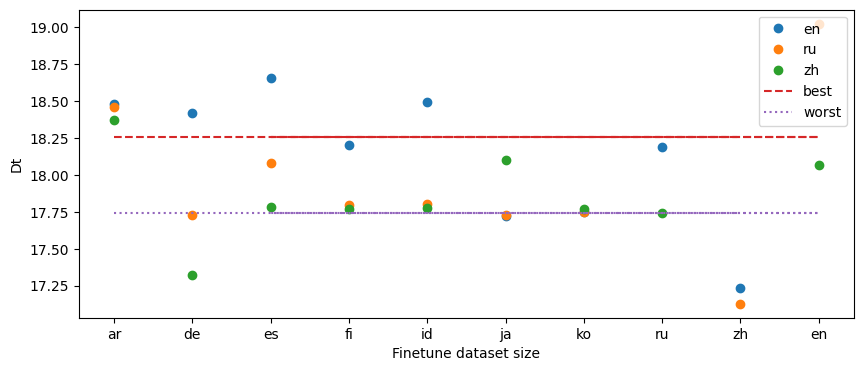

In [517]:
lang_table_6m = estimated_dt_table[SIZE_6M].reset_index()

plot_by(
    lang_table_6m,
    "source",
    "target",
    "dt",
    logx=False,
    logy=True,
    type="o")

on_max = lang_table_6m.groupby("target")[["dt", "source"]].idxmax(numeric_only=True)
on_min = lang_table_6m.groupby("target")[["dt", "source"]].idxmin(numeric_only=True)

best_on_every_language = lang_table_6m.iloc[on_max["dt"]][["source", "target", "dt"]]
worst_on_every_language = lang_table_6m.iloc[on_min["dt"]][["source", "target", "dt"]]

mplt.plot(best_on_every_language["target"], [np.log(best_on_every_language["dt"]).mean()] * len(best_on_every_language["target"]), "--", label="best")
mplt.plot(worst_on_every_language["target"], [np.log(worst_on_every_language["dt"]).mean()] * len(worst_on_every_language["target"]), ":", label="worst")

mplt.legend()

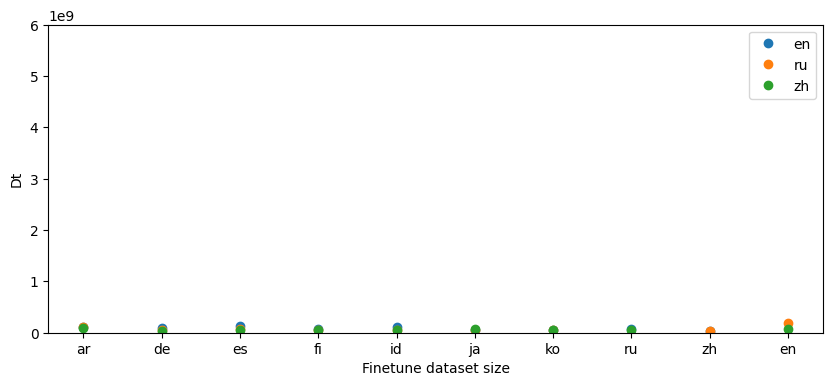

In [518]:
plot_by(
    lang_table_6m,
    "source",
    "target",
    "dt",
    logx=False,
    logy=False,
    type="o",
    ymin_max=(0, 6000000000))

In [519]:
estimated_dt_table[SIZE_6M].reset_index()

,index,source,target,size,perplexity,scratch_perplexity,dt,de,df,fraction_of_effective_dt,dt_formatted,df_formatted,de_formatted
0,0,en,ar,6000000,2.818745,6.443963,1.059319e+08,1.119319e+08,6000000,0.946396,101.02 MB,5.72 MB,106.75 MB
1,6,en,de,6000000,3.666850,14.815842,9.987413e+07,1.058741e+08,6000000,0.943329,95.25 MB,5.72 MB,100.97 MB
2,12,en,es,6000000,3.163111,12.539025,1.270209e+08,1.330209e+08,6000000,0.954894,121.14 MB,5.72 MB,126.86 MB
3,18,en,fi,6000000,3.568337,12.714645,8.029443e+07,8.629443e+07,6000000,0.930471,76.57 MB,5.72 MB,82.30 MB
4,24,en,id,6000000,2.609680,11.997169,1.076085e+08,1.136085e+08,6000000,0.947187,102.62 MB,5.72 MB,108.35 MB
5,30,en,ja,6000000,3.919586,12.468638,4.980689e+07,5.580689e+07,6000000,0.892486,47.50 MB,5.72 MB,53.22 MB
6,36,en,ko,6000000,3.579865,11.686792,5.110478e+07,5.710478e+07,6000000,0.894930,48.74 MB,5.72 MB,54.46 MB
7,42,en,ru,6000000,2.443826,6.269366,7.931563e+07,8.531563e+07,6000000,0.929673,75.64 MB,5.72 MB,81.36 MB
8,48,en,zh,6000000,4.425953,15.340176,3.062883e+07,3.662883e+07,6000000,0.836195,29.21 MB,5.72 MB,34.93 MB
9,54,zh,ar,6000000,2.880094,6.443963,9.503516e+07,1.010352e+08,6000000,0.940615,90.63 MB,5.72 MB,96.35 MB


Another hypothesis is that the models, regardless of pretraining, have very similar transfer abilities. So we plot a boxplot by Source Language to check if we have any indication of this

dt    Axes(0.125,0.11;0.775x0.77)
dtype: object

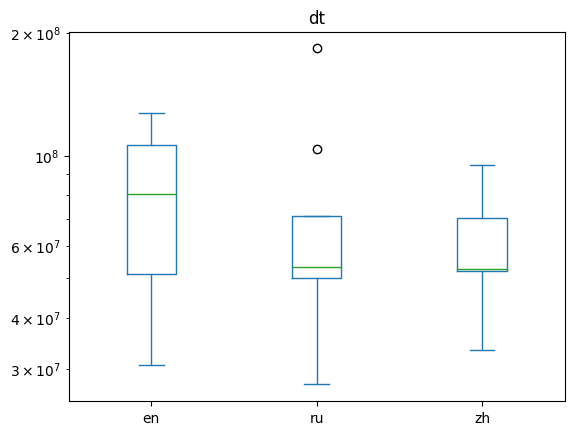

In [520]:
estimated_dt_table[(estimated_dt_table["size"] == 6000000)].plot.box(column="dt", by="source", logy=True)

## Analyzing D<sub>T</sub> across target languages

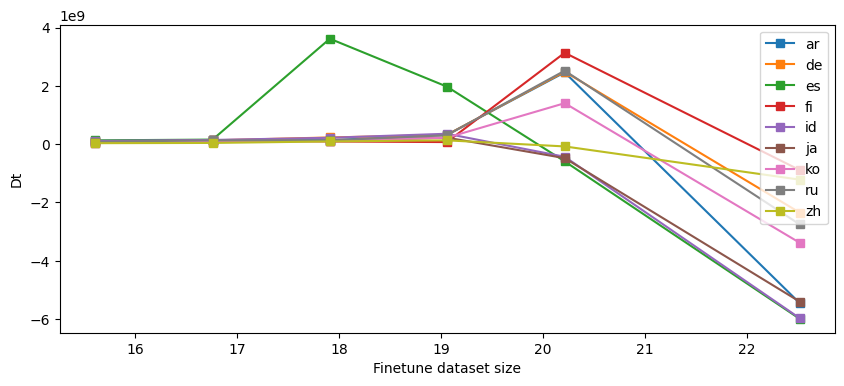

In [521]:
plot_by(estimated_dt_table[estimated_dt_table["source"] == "en"].reset_index(), "target", "size", "dt")

/Users/leandro.desouza/Source/lersouza/language-transfer/.lang_transfer/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


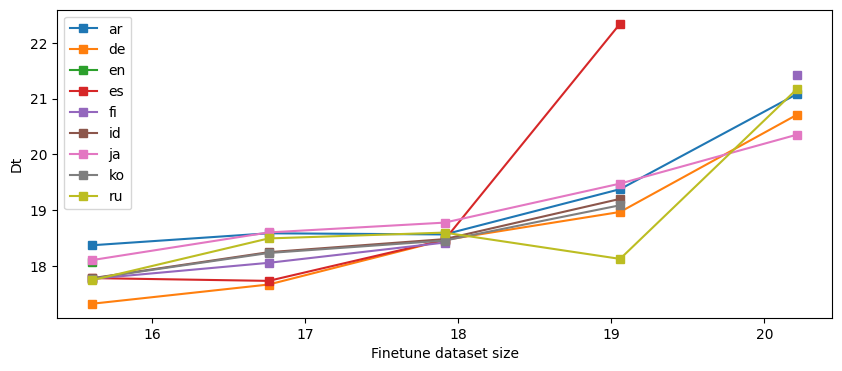

In [522]:
plot_by(estimated_dt_table[estimated_dt_table["source"] == "zh"].reset_index(), "target", "size", "dt", logy=True)

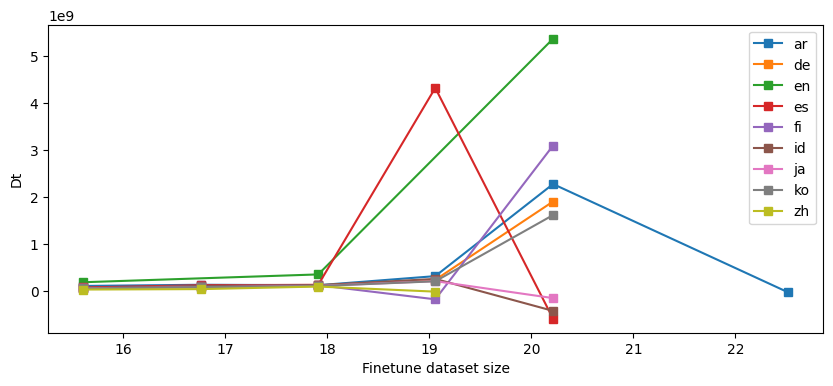

In [523]:
plot_by(estimated_dt_table[estimated_dt_table["source"] == "ru"].reset_index(), "target", "size", "dt")

In [524]:
estimated_dt_table[(estimated_dt_table["size"] == 6000000) & (estimated_dt_table["target"] == "de")]

,source,target,size,perplexity,scratch_perplexity,dt,de,df,fraction_of_effective_dt,dt_formatted,df_formatted,de_formatted
6,en,de,6000000,3.666850,14.815842,9.987413e+07,1.058741e+08,6000000,0.943329,95.25 MB,5.72 MB,100.97 MB
60,zh,de,6000000,4.264022,14.815842,3.330020e+07,3.930020e+07,6000000,0.847329,31.76 MB,5.72 MB,37.48 MB
112,ru,de,6000000,3.984010,14.815842,5.019782e+07,5.619782e+07,6000000,0.893234,47.87 MB,5.72 MB,53.59 MB


In [525]:
estimated_dt_table[(estimated_dt_table["size"] == 6000000) & (estimated_dt_table["target"] == "id")]

,source,target,size,perplexity,scratch_perplexity,dt,de,df,fraction_of_effective_dt,dt_formatted,df_formatted,de_formatted
24,en,id,6000000,2.609680,11.997169,1.076085e+08,1.136085e+08,6000000,0.947187,102.62 MB,5.72 MB,108.35 MB
82,zh,id,6000000,2.977077,11.997169,5.264918e+07,5.864918e+07,6000000,0.897697,50.21 MB,5.72 MB,55.93 MB
134,ru,id,6000000,2.836732,11.997169,5.380960e+07,5.980960e+07,6000000,0.899682,51.32 MB,5.72 MB,57.04 MB


In [526]:
estimated_dt_table[(estimated_dt_table["size"] == 6000000) & (estimated_dt_table["target"] == "ja")]

,source,target,size,perplexity,scratch_perplexity,dt,de,df,fraction_of_effective_dt,dt_formatted,df_formatted,de_formatted
30,en,ja,6000000,3.919586,12.468638,4.980689e+07,5.580689e+07,6000000,0.892486,47.50 MB,5.72 MB,53.22 MB
88,zh,ja,6000000,3.456637,12.468638,7.285078e+07,7.885078e+07,6000000,0.923907,69.48 MB,5.72 MB,75.20 MB
140,ru,ja,6000000,3.891109,12.468638,5.013154e+07,5.613154e+07,6000000,0.893108,47.81 MB,5.72 MB,53.53 MB


In [527]:
estimated_dt_table[(estimated_dt_table["size"] == 6000000) & (estimated_dt_table["target"] == "ko")]

,source,target,size,perplexity,scratch_perplexity,dt,de,df,fraction_of_effective_dt,dt_formatted,df_formatted,de_formatted
36,en,ko,6000000,3.579865,11.686792,5.110478e+07,5.710478e+07,6000000,0.894930,48.74 MB,5.72 MB,54.46 MB
94,zh,ko,6000000,3.477913,11.686792,5.230758e+07,5.830758e+07,6000000,0.897097,49.88 MB,5.72 MB,55.61 MB
146,ru,ko,6000000,3.584079,11.686792,5.105506e+07,5.705506e+07,6000000,0.894838,48.69 MB,5.72 MB,54.41 MB


In [528]:
estimated_dt_table[(estimated_dt_table["size"] == 6000000) & (estimated_dt_table["target"] == "ar")]

,source,target,size,perplexity,scratch_perplexity,dt,de,df,fraction_of_effective_dt,dt_formatted,df_formatted,de_formatted
0,en,ar,6000000,2.818745,6.443963,1.059319e+08,1.119319e+08,6000000,0.946396,101.02 MB,5.72 MB,106.75 MB
54,zh,ar,6000000,2.880094,6.443963,9.503516e+07,1.010352e+08,6000000,0.940615,90.63 MB,5.72 MB,96.35 MB
106,ru,ar,6000000,2.830716,6.443963,1.038057e+08,1.098057e+08,6000000,0.945358,99.00 MB,5.72 MB,104.72 MB


## Assessing the impact of language contamination

We read data for data contamination in the pretraining dataset

In [529]:
language_contamination_data = pd.concat([pd.read_csv(f"../results/languages_in_{l}_6B_byline_dataset.csv") for l in SOURCE_LANGUAGES])
language_contamination_data.head()

,source_language,size,target_language,sentences
0,en,6B,__label__other,6021811
1,en,6B,__label__en,21933341
2,en,6B,__label__de,49862
3,en,6B,__label__fr,44873
4,en,6B,__label__vi,4810


Calculate the ration of each language for the dataset

In [530]:
all_sequences = language_contamination_data.groupby("source_language")["sentences"].sum()
all_sequences

source_language
en    28216357
ru    17315757
zh    16915882
Name: sentences, dtype: int64

In [531]:
language_contamination_data["lang_ratio"] = language_contamination_data.apply(lambda r: r["sentences"] / all_sequences[r["source_language"]], axis=1)
language_contamination_data.head()

,source_language,size,target_language,sentences,lang_ratio
0,en,6B,__label__other,6021811,0.213416
1,en,6B,__label__en,21933341,0.777327
2,en,6B,__label__de,49862,0.001767
3,en,6B,__label__fr,44873,0.001590
4,en,6B,__label__vi,4810,0.000170


In [532]:
language_contamination_data.describe()

,sentences,lang_ratio
count,3.280000e+02,3.280000e+02
mean,1.903902e+05,9.146341e-03
std,1.697703e+06,8.032278e-02
min,1.000000e+00,3.544044e-08
25%,4.000000e+00,1.773481e-07
50%,4.750000e+01,2.286857e-06
75%,3.747500e+02,1.892429e-05
max,2.193334e+07,9.102415e-01


Normalize the language name, for joining with the D<sub>T</sub> estimations

In [533]:
language_contamination_data["target_language_name"] = language_contamination_data["target_language"].apply(lambda e: e.split("_")[-1])
language_contamination_data.head()

,source_language,size,target_language,sentences,lang_ratio,target_language_name
0,en,6B,__label__other,6021811,0.213416,other
1,en,6B,__label__en,21933341,0.777327,en
2,en,6B,__label__de,49862,0.001767,de
3,en,6B,__label__fr,44873,0.001590,fr
4,en,6B,__label__vi,4810,0.000170,vi


And, then, join and caculate the corralation

In [534]:
estimation_with_contamination = estimated_dt_table.merge(
    language_contamination_data,
    "inner",
    left_on=["source", "target"],
    right_on=["source_language", "target_language_name"])

estimation_with_contamination.head(20)

,source,target,size_x,perplexity,scratch_perplexity,dt,de,df,fraction_of_effective_dt,dt_formatted,df_formatted,de_formatted,source_language,size_y,target_language,sentences,lang_ratio,target_language_name
0,en,ar,6000000,2.818745,6.443963,1.059319e+08,1.119319e+08,6000000,0.946396,101.02 MB,5.72 MB,106.75 MB,en,6B,__label__ar,2515,0.000089,ar
1,en,ar,19000000,2.573541,5.398603,1.364847e+08,1.554847e+08,19000000,0.877801,130.16 MB,18.12 MB,148.28 MB,en,6B,__label__ar,2515,0.000089,ar
2,en,ar,60000000,2.382326,3.111124,1.327154e+08,1.927154e+08,60000000,0.688660,126.57 MB,57.22 MB,183.79 MB,en,6B,__label__ar,2515,0.000089,ar
3,en,ar,189000000,2.169670,2.384848,3.170269e+08,5.060269e+08,189000000,0.626502,302.34 MB,180.24 MB,482.58 MB,en,6B,__label__ar,2515,0.000089,ar
4,en,ar,600000000,2.025625,2.105888,2.459007e+09,3.059007e+09,600000000,0.803858,"2,345.09 MB",572.20 MB,"2,917.30 MB",en,6B,__label__ar,2515,0.000089,ar
5,en,ar,6000000000,2.141356,1.929630,-5.452257e+09,5.477426e+08,6000000000,0.000000,"-5,199.68 MB","5,722.05 MB",522.37 MB,en,6B,__label__ar,2515,0.000089,ar
6,en,de,6000000,3.666850,14.815842,9.987413e+07,1.058741e+08,6000000,0.943329,95.25 MB,5.72 MB,100.97 MB,en,6B,__label__de,49862,0.001767,de
7,en,de,19000000,3.440617,10.295130,1.277086e+08,1.467086e+08,19000000,0.870492,121.79 MB,18.12 MB,139.91 MB,en,6B,__label__de,49862,0.001767,de
8,en,de,60000000,3.107374,3.921004,2.270794e+08,2.870794e+08,60000000,0.790999,216.56 MB,57.22 MB,273.78 MB,en,6B,__label__de,49862,0.001767,de
9,en,de,189000000,2.889578,3.206312,3.139865e+08,5.029865e+08,189000000,0.624244,299.44 MB,180.24 MB,479.69 MB,en,6B,__label__de,49862,0.001767,de


Calculating the Spearman Correlation Coefficient (monotonic relation) $r$<sub>s</sub> between D<sub>T</sub> and the ration of target language in the source corpora.

In [535]:
estimation_with_contamination[["dt", "fraction_of_effective_dt", "lang_ratio", "perplexity"]].corr("spearman")

,dt,fraction_of_effective_dt,lang_ratio,perplexity
dt,1.000000,0.364591,0.129318,-0.119956
fraction_of_effective_dt,0.364591,1.000000,0.116743,0.514412
lang_ratio,0.129318,0.116743,1.000000,0.119332
perplexity,-0.119956,0.514412,0.119332,1.000000


Since the coefficient is close to 0, we can conclude that there is neither a linear nor monotonic relationship between the variables, which we interpret as the language contamination in the source dataset not being determinant for the transfer between source and target.

## Language Contamination on Target

In [536]:
language_contamination_on_target = pd.concat(map(pd.read_csv, [str(p) for p in Path("../results/").glob("*_6M_byline_dataset.csv")]))
language_contamination_on_target.head()

,source_language,size,target_language,sentences
0,ar,6M,__label__ar,21853
1,ar,6M,__label__other,1618
2,ar,6M,__label__en,331
3,ar,6M,__label__arz,163
4,ar,6M,__label__fr,41


In [537]:
all_sequences_on_target = language_contamination_on_target.groupby("source_language")["sentences"].sum()
all_sequences_on_target

source_language
ar    24094
de    35882
en    30691
es    30050
fi    34539
id    36083
ja    22725
ko    24070
pt    34439
ru    20651
zh    18535
Name: sentences, dtype: int64

In [538]:
language_contamination_on_target["lang_ratio"] = language_contamination_on_target.apply(lambda r: r["sentences"] / all_sequences_on_target[r["source_language"]], axis=1)
language_contamination_on_target.head()

,source_language,size,target_language,sentences,lang_ratio
0,ar,6M,__label__ar,21853,0.906989
1,ar,6M,__label__other,1618,0.067154
2,ar,6M,__label__en,331,0.013738
3,ar,6M,__label__arz,163,0.006765
4,ar,6M,__label__fr,41,0.001702


In [539]:
language_contamination_on_target["target_language_name"] = language_contamination_on_target["target_language"].apply(lambda e: e.split("_")[-1])
language_contamination_on_target.head()

,source_language,size,target_language,sentences,lang_ratio,target_language_name
0,ar,6M,__label__ar,21853,0.906989,ar
1,ar,6M,__label__other,1618,0.067154,other
2,ar,6M,__label__en,331,0.013738,en
3,ar,6M,__label__arz,163,0.006765,arz
4,ar,6M,__label__fr,41,0.001702,fr


In [540]:
estimation_with_contamination_on_target = estimated_dt_table.merge(
    language_contamination_on_target,
    "inner",
    left_on=["target", "source"],
    right_on=["source_language", "target_language_name"])

estimation_with_contamination_on_target.head(20)

,source,target,size_x,perplexity,scratch_perplexity,dt,de,df,fraction_of_effective_dt,dt_formatted,df_formatted,de_formatted,source_language,size_y,target_language,sentences,lang_ratio,target_language_name
0,en,ar,6000000,2.818745,6.443963,1.059319e+08,1.119319e+08,6000000,0.946396,101.02 MB,5.72 MB,106.75 MB,ar,6M,__label__en,331,0.013738,en
1,en,ar,19000000,2.573541,5.398603,1.364847e+08,1.554847e+08,19000000,0.877801,130.16 MB,18.12 MB,148.28 MB,ar,6M,__label__en,331,0.013738,en
2,en,ar,60000000,2.382326,3.111124,1.327154e+08,1.927154e+08,60000000,0.688660,126.57 MB,57.22 MB,183.79 MB,ar,6M,__label__en,331,0.013738,en
3,en,ar,189000000,2.169670,2.384848,3.170269e+08,5.060269e+08,189000000,0.626502,302.34 MB,180.24 MB,482.58 MB,ar,6M,__label__en,331,0.013738,en
4,en,ar,600000000,2.025625,2.105888,2.459007e+09,3.059007e+09,600000000,0.803858,"2,345.09 MB",572.20 MB,"2,917.30 MB",ar,6M,__label__en,331,0.013738,en
5,en,ar,6000000000,2.141356,1.929630,-5.452257e+09,5.477426e+08,6000000000,0.000000,"-5,199.68 MB","5,722.05 MB",522.37 MB,ar,6M,__label__en,331,0.013738,en
6,en,de,6000000,3.666850,14.815842,9.987413e+07,1.058741e+08,6000000,0.943329,95.25 MB,5.72 MB,100.97 MB,de,6M,__label__en,684,0.019062,en
7,en,de,19000000,3.440617,10.295130,1.277086e+08,1.467086e+08,19000000,0.870492,121.79 MB,18.12 MB,139.91 MB,de,6M,__label__en,684,0.019062,en
8,en,de,60000000,3.107374,3.921004,2.270794e+08,2.870794e+08,60000000,0.790999,216.56 MB,57.22 MB,273.78 MB,de,6M,__label__en,684,0.019062,en
9,en,de,189000000,2.889578,3.206312,3.139865e+08,5.029865e+08,189000000,0.624244,299.44 MB,180.24 MB,479.69 MB,de,6M,__label__en,684,0.019062,en


In [541]:
estimation_with_contamination_on_target[["dt", "fraction_of_effective_dt", "lang_ratio", "perplexity"]].corr("spearman")

,dt,fraction_of_effective_dt,lang_ratio,perplexity
dt,1.000000,0.366176,-0.001304,-0.127995
fraction_of_effective_dt,0.366176,1.000000,-0.057366,0.532711
lang_ratio,-0.001304,-0.057366,1.000000,-0.106857
perplexity,-0.127995,0.532711,-0.106857,1.000000
